**Group-08**<br/>
<font style="color:red"> **Belhassen Ghoul <br/> Robin Ehrensperger <br/> Dominic Diedenhofen**</font>

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Loading the Data

In [10]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

### Model

In [11]:
class MLP(torch.nn.Module):    
    def __init__(self, params):
        super(MLP, self).__init__()
        self.units = params[1]
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(params[0],params[1])
        self.ReLU = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(params[1],params[2])
        self.ReLU2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(params[2],params[3])

    def forward(self, x):
        z = self.linear1(self.flatten(x))
        z = self.ReLU(z)
        z = self.linear2(z)
        z = self.ReLU2(z)
        return self.linear3(z)



In [12]:
# your favourite MLP model

model = MLP([28*28,200,80,10])



In [13]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 80]          16,080
              ReLU-5                   [-1, 80]               0
            Linear-6                   [-1, 10]             810
Total params: 173,890
Trainable params: 173,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.66
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


### Train-Eval over a given number of epochs for a given train/validation loader (4+1 fold)

In [14]:
def train_eval(nepochs, model, lr, trainloader, validloader, cost_fn):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    
    for epoch in range(nepochs):
        model.train()
        cost, acc = 0.0, 0.0
        for (X, Y) in trainloader:
            pred = model(X)
            loss = cost_fn(pred, Y)
            cost += loss.item()/len(trainloader)
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()/len(trainloader.dataset)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        
        
        model.eval()
        cost_test,acc_test = 0.0,0.0
        with torch.no_grad():
            for (X,Y) in validloader:
                pred = model(X)
                cost_test += cost_fn(pred, Y).item()/len(validloader)
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).mean().item()/len(validloader)
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)

    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Split Training Data into folds

Prepare specific loaders for the 4 training folds and the 1 validation fold

Suggestions:
* Use sklearns KFold functionality for spliiting into folds.
* Use pytorchs subsamplers (torch.utils.data.SubsetRandomSampler) to construct training and validation loaders

In [15]:
# Configuration options
from torch.utils.data import SubsetRandomSampler

nfolds = 5
nepochs = 20
lr = 0.3
batchsize = 64
kfold = KFold(n_splits=nfolds)

datasetSize = len(training_data)
datasetIndices = list(range(datasetSize))
np.random.shuffle(datasetIndices)
valSplitIndex = int(np.floor(0.2*datasetSize))
train_ids, valid_ids = datasetIndices[valSplitIndex:],datasetIndices[:valSplitIndex]
trainSampler = SubsetRandomSampler(train_ids)
valSampler = SubsetRandomSampler(valid_ids)

trainloader = DataLoader(training_data, batch_size=batchsize, shuffle=False, sampler=trainSampler)
validloader = DataLoader(training_data, batch_size=batchsize, shuffle=False, sampler=valSampler)

cost_fn = torch.nn.CrossEntropyLoss()
results = {}


In [16]:
for fold, (train_ids, valid_ids) in enumerate(kfold.split(training_data)):

    print(f'FOLD {fold}')
    print('--------------------------------')    
    results[fold] = train_eval(nepochs, model, lr, trainloader, validloader, cost_fn) 

FOLD 0
--------------------------------
Epoch 0: 0.655775, 0.604300, 0.475076, 0.825964
Epoch 1: 0.428561, 0.673083, 0.415827, 0.842753
Epoch 2: 0.381773, 0.685783, 0.459216, 0.827294
Epoch 3: 0.350710, 0.694750, 0.391844, 0.859874
Epoch 4: 0.329049, 0.700667, 0.341342, 0.876662
Epoch 5: 0.307862, 0.707583, 0.329457, 0.880070
Epoch 6: 0.297784, 0.709867, 0.349655, 0.871177
Epoch 7: 0.283073, 0.713950, 0.351187, 0.870512
Epoch 8: 0.275593, 0.716333, 0.389013, 0.863697
Epoch 9: 0.265559, 0.718467, 0.330111, 0.879820
Epoch 10: 0.257035, 0.721250, 0.320278, 0.888298
Epoch 11: 0.247762, 0.723783, 0.317068, 0.884475
Epoch 12: 0.241318, 0.726167, 0.314034, 0.891207
Epoch 13: 0.234551, 0.727883, 0.332093, 0.884558
Epoch 14: 0.230202, 0.729017, 0.331259, 0.884225
Epoch 15: 0.221359, 0.731350, 0.309636, 0.890043
Epoch 16: 0.216475, 0.733800, 0.353496, 0.878823
Epoch 17: 0.216282, 0.733500, 0.361806, 0.874418
Epoch 18: 0.208036, 0.736850, 0.324891, 0.891539
Epoch 19: 0.204025, 0.737583, 0.336776,

### Prepare output plots

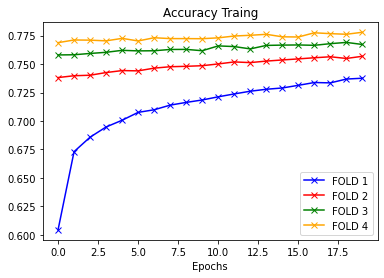

In [17]:
colors = ["blue","red","green","orange"]
marker = ["x","o","m-","g-","y-"]

for i in range(4):
    test = torch.FloatTensor(results[i])
    plt.plot(torch.arange(nepochs), test[2,:], color = colors[i], marker = "x", label = f'FOLD {i+1}')
plt.title("Accuracy Traing")
plt.xlabel("Epochs")
plt.legend()
plt.show()

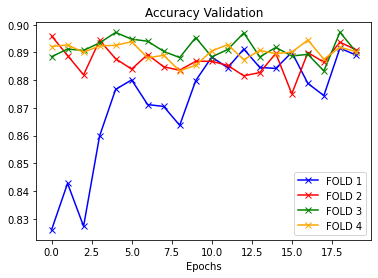

In [18]:
colors = ["blue","red","green","orange"]
marker = ["x","o","m-","g-","y-"]

for i in range(4):
    test = torch.FloatTensor(results[i])
    plt.plot(torch.arange(nepochs), test[3,:], color = colors[i], marker = "x", label = f'FOLD {i+1}')
plt.title("Accuracy Validation")
plt.xlabel("Epochs")
plt.legend()
plt.show()